https://huggingface.co/docs/transformers/model_doc/segformer

## Loading data and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import functional as FT
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from tqdm import tqdm

import os
import numpy as np

import matplotlib.pyplot as plt

import cv2 as cv

import pandas as pd

from datetime import datetime

from sklearn import metrics as skmetrics

In [ ]:
train_images = np.load("/content/drive/MyDrive/VCS Project/dataset/train/images/images.npy", allow_pickle=True)
train_masks = np.load("/content/drive/MyDrive/VCS Project/dataset/train/masks/masks.npy", allow_pickle=True)

## Exploring the dataset

The train dataset consists of 60 images each at a different resolution and slices >= 15

In [ ]:
def show_images(image, colorm='viridis'):
  num_slices = image.shape[2]
  fig, axes = plt.subplots(1, num_slices, figsize=(100, 100))
  for i in range(num_slices):
      axes[i].imshow(image[:, :, i], cmap=colorm)
      axes[i].set_title(f'Slice {i + 1}')

  plt.show()

# Showing Images and Masks

def display_image_with_mask(image, mask, alpha=0.35):
    num_slices = image.shape[2]
    fig, axes = plt.subplots(1, num_slices, figsize=(100, 100))

    for i in range(num_slices):

        axes[i].imshow(image[:, :, i], cmap='gray')
        axes[i].set_title(f'Slice {i + 1}')

        axes[i].imshow(mask[:, :, i], cmap='Reds', alpha=alpha)

    plt.show()

def display_1_im_mask(image, mask, alpha=0.5):
    fig, axes = plt.subplots(1, 1, figsize=(75, 75))
    axes.imshow(image, cmap='gray')
    axes.imshow(mask, cmap='Reds', alpha=alpha)
    plt.show()

## Dataset creation

We create the custom dataset, where we have the input images and masks

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
class ProstateMRIDataset(Dataset):
    def __init__(self, images, masks, device, transform=None, reduce_label=False):
      # input is already flattened image, so each element of input is an image
        self.images = images
        self.masks = masks
        self.transform = transform
        self.device = device
        # another option get most common dimension of images as target size
        # shapes = np.array([image.shape for image in images])
        # unique_tuples, counts = np.unique(shapes, axis=0, return_counts=True)
        # self.target_size = unique_tuples[np.argmax(counts)]
        self.target_size = (256, 256)
        self.reduce_label = reduce_label


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        assert image.shape == mask.shape, "Input image and mask must have same dimensions"

        # resize images
          # resize down
        if image.shape[0] > self.target_size[0]:
          interpolation = cv.INTER_AREA
          image = cv.resize(image, self.target_size, interpolation=interpolation)
          mask = cv.resize(mask, self.target_size, interpolation=interpolation)
          # resize up
        elif image.shape[0] < self.target_size[0]:
          interpolation = cv.INTER_CUBIC
          image = cv.resize(image, self.target_size, interpolation=interpolation)
          mask = cv.resize(mask, self.target_size, interpolation=interpolation)

        # Do label reduction of mask, 0 is background in our dataset
        if self.reduce_label:
          mask[mask == 0] = 255 # 255 is default ignore index of SegFormer
          mask = mask - 1
          mask[mask == 254] = 255

        image = torch.from_numpy(image).unsqueeze(0)
        # no need to do unsqueeze top add a dimension of size 1 at 0 for masks
        mask = torch.from_numpy(mask)#.unsqueeze(0)

        assert image.shape[0] == 1, "Input image must have a single channel"

        # return just mask
        return image.to(self.device), mask.to(self.device, dtype=torch.int64)

In [ ]:
from sklearn.model_selection import train_test_split

test_size_initial = 0.2

train_images_filtered, test_images_filtered, train_masks_filtered, test_masks_filtered = train_test_split(
    train_images, train_masks, test_size=test_size_initial, random_state=42)

validation_size = 0.1

train_images_filtered, validation_images_filtered, train_masks_filtered, validation_masks_filtered = train_test_split(
    train_images_filtered, train_masks_filtered, test_size=validation_size, random_state=42)

In [ ]:
def flatten_slices(images):
    return np.array([image[:, :, i] for image in images for i in range(image.shape[2])])

train_images_flatten = flatten_slices(train_images_filtered)
train_masks_flatten = flatten_slices(train_masks_filtered)

validation_images_flatten = flatten_slices(validation_images_filtered)
validation_masks_flatten = flatten_slices(validation_masks_filtered)

test_images_flatten = flatten_slices(test_images_filtered)
test_masks_flatten = flatten_slices(test_masks_filtered)

In [ ]:
id2label = {0: 'background',
              1: 'peripheral zone',
              2: 'central gland'}

label2id = {v: k for k, v in id2label.items()}

## Data Augmentation

Histogram equalization


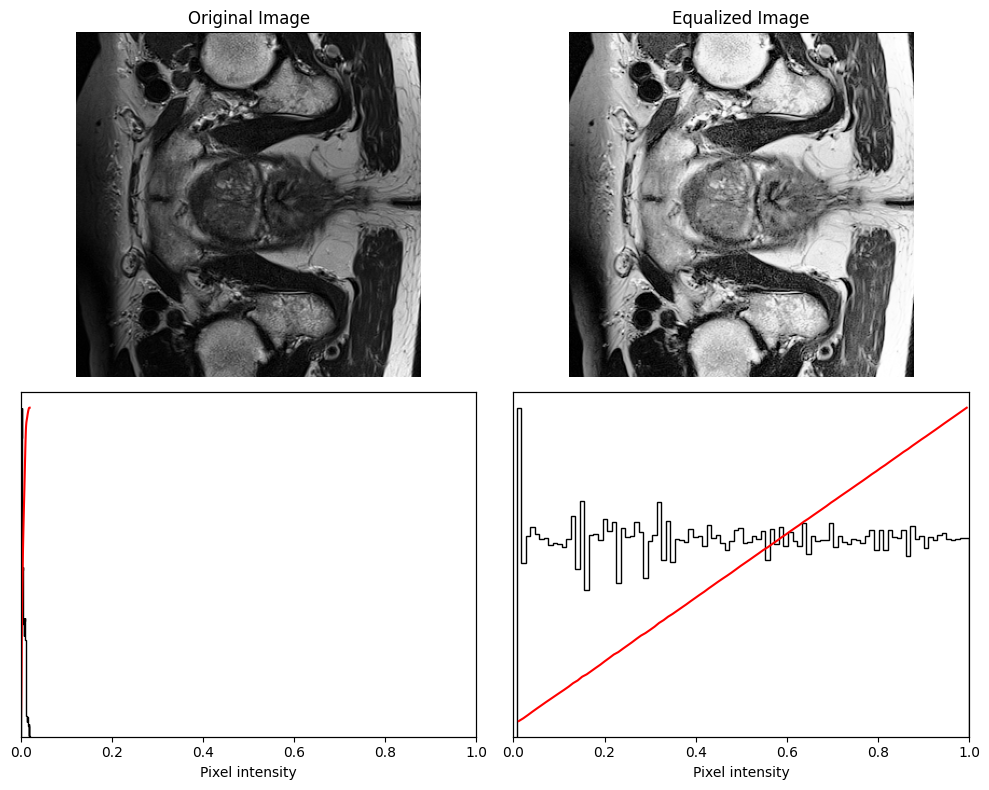

In [ ]:
from skimage import exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np

def hist_equalise(dataset):
    # Perform histogram equalization on each scan slice
    for i in range(len(dataset)): # Over subjects
          dataset[i] = exposure.equalize_hist(dataset[i])

def plot_img_and_hist(image, axes, bins=100):
    # Plot an image along with its histogram and cumulative histogram.
    # Code adapted from: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

def plot_histogram_equalisation(img_org, img_heq):
    # Plot original low contrast image and histogram eualised image, with their histograms and cumulative histograms.
    # Code adapted from: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

    fig = plt.figure(figsize=(7, 7))
    axes = np.zeros((2, 2), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 2, 1)
    for i in range(1, 2):
        axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 2):
        axes[1, i] = fig.add_subplot(2, 2, 3+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_org, axes[:, 0])
    ax_img.set_title('Original low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_heq, axes[:, 1])
    ax_img.set_title('Histogram equalised image')

    ax_cdf.set_ylabel('Fraction of total intensity', color='red')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    fig.tight_layout(h_pad=-1.5)
    plt.show()

def visualize_histogram_equalization(original, equalized):
    # Visualize original and equalized images with their histograms
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    plot_img_and_hist(original, axes[:, 0])
    axes[0, 0].set_title('Original Image')

    plot_img_and_hist(equalized, axes[:, 1])
    axes[0, 1].set_title('Equalized Image')

    plt.tight_layout()
    plt.show()


# Visualize the results for a single subject and slice (modify indices as needed)
subject_index = 8
original_image = train_images_flatten[subject_index]
equalized_image = exposure.equalize_hist(original_image)

# Visualize the results
visualize_histogram_equalization(original_image, equalized_image)

# Apply histogram equalization to the datasets
hist_equalise(train_images_flatten)
hist_equalise(validation_images_flatten)
hist_equalise(test_images_flatten)

In [ ]:
from scipy.ndimage import map_coordinates, gaussian_filter
import scipy
import time
import numpy as np
import random

def rotate(voxels, lbls, theta=None):
    # Rotate volume by a minor angle (+/- 10 degrees: determined by investigation of dataset variability)
    if theta is None:
        theta = random.randint(-10, 10)
    vox_new = scipy.ndimage.rotate(voxels, theta, reshape=False)
    lbl_new = scipy.ndimage.rotate(lbls, theta, reshape=False)
    return vox_new, lbl_new


def scale_and_crop(voxels, lbls):
    # Scale the volume by a minor size and crop around centre (can also modify for random crop)
    o_s = voxels.shape
    r_s = [0] * len(o_s)
    scale_factor = random.uniform(1, 1.2)
    vox_zoom = scipy.ndimage.zoom(voxels, scale_factor, order=1)
    lbl_zoom = scipy.ndimage.zoom(lbls, scale_factor, order=0)
    new_shape = vox_zoom.shape
    # Start with offset
    for i in range(len(o_s)):
        if new_shape[i] == 1:
            r_s[i] = 0
            continue
        r_c = int(((new_shape[i] - o_s[i]) - 1) / 2)
        r_s[i] = r_c
    r_e = [r_s[i] + o_s[i] for i in range(len(o_s))]

    # Adjust indexing for 2D arrays
    vox_zoom = vox_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1]]
    lbl_zoom = lbl_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1]]


    return vox_zoom, lbl_zoom

def grayscale_variation(voxels, lbls):
    # Introduce a random global increment in gray-level value of volume.
    im_min = np.min(voxels)
    im_max = np.max(voxels)
    mean = np.random.normal(0, 0.1)
    smp = np.random.normal(mean, 0.01, size=np.shape(voxels))
    voxels = voxels + im_max * smp
    voxels[voxels <= im_min] = im_min  # Clamp to min value
    voxels[voxels > im_max] = im_max  # Clamp to max value
    return voxels, lbls


def elastic_deformation(voxels, lbls, alpha=None, sigma=None, mode="constant", cval=0, is_random=False):
    # Apply elastic deformation/distortion to the volume
    # Adapted from: https://tensorlayer.readthedocs.io/en/stable/_modules/tensorlayer/prepro.html#elastic_transform
    if alpha is None:
        alpha = voxels.shape[0] * 3.0
    if sigma is None:
        sigma = voxels.shape[0] * 0.07
    if is_random is False:
        random_state = np.random.RandomState(None)
    else:
        random_state = np.random.RandomState(int(time.time()))

    shape = voxels.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    x_, y_ = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x_ + dx, (-1, 1)), np.reshape(y_ + dy, (-1, 1))

    new_voxels = np.zeros_like(voxels)
    new_lbls = np.zeros_like(lbls)
    new_voxels[:, :] = map_coordinates(voxels[:, :], indices, order=1).reshape(shape[:2])
    new_lbls[:, :] = map_coordinates(lbls[:, :], indices, order=1).reshape(shape[:2])

    return new_voxels, new_lbls

def get_random_perturbation(voxels, lbls):
    # Generate a random perturbation of the input feature + label
    new_voxels, new_lbls = voxels, lbls
    p = 0.6
    if random.random() < p:
        new_voxels, new_lbls = rotate(new_voxels, new_lbls)
    if random.random() < p:
        new_voxels, new_lbls = scale_and_crop(new_voxels, new_lbls)
    if random.random() < p:
        new_voxels, new_lbls = grayscale_variation(new_voxels, new_lbls)
    if random.random() < p:
        new_voxels, new_lbls = elastic_deformation(new_voxels, new_lbls)
    return new_voxels, new_lbls

In [ ]:
import copy

# Assuming train_images_filtered and train_masks_filtered are your original datasets
# Create new lists to store augmented images and masks
augmented_train_images = []
augmented_train_masks = []

# Number of augmentations per original pair
num_augmentations = 2

# Apply perturbation and save augmented pairs
for i in range(len(train_images_flatten)):
    original_image = train_images_flatten[i]
    original_mask = train_masks_flatten[i]

    augmented_train_images.append(original_image)
    augmented_train_masks.append(original_mask)

    for _ in range(num_augmentations):
        augmented_image, augmented_mask = get_random_perturbation(copy.deepcopy(original_image),
                                                                  copy.deepcopy(original_mask))
        augmented_train_images.append(augmented_image)
        augmented_train_masks.append(augmented_mask)

## Data loader creation

Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = ProstateMRIDataset(np.array(augmented_train_images), np.array(augmented_train_masks), device=device)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

<ipython-input-24-a3062eb9eae9>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_dataset = ProstateMRIDataset(np.array(augmented_train_images), np.array(augmented_train_masks), device=device)


Test & validation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

validation_dataset = ProstateMRIDataset(np.array(validation_images_flatten), np.array(validation_masks_flatten), device)
test_dataset = ProstateMRIDataset(np.array(test_images_flatten), np.array(test_masks_flatten), device)

validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

https://arxiv.org/pdf/1511.00561.pdf

https://github.com/vinceecws/SegNet_PyTorch/tree/master

## Model definition: import pre trained

We start off by loading the pre trained model if we have no previous checkpoints.

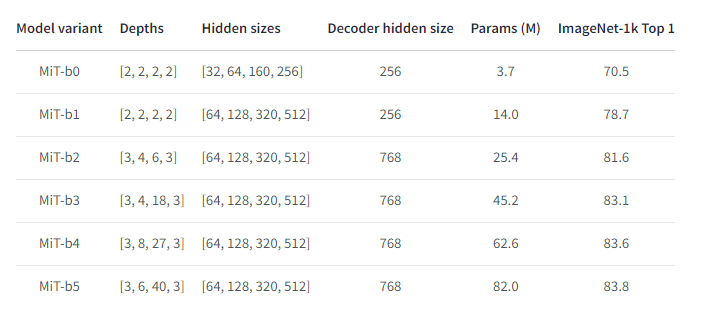

In [ ]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig

# Load SegformerForSemanticSegmentation with pretrained weights
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", # select model
                                                         num_labels=len(id2label),
                                                         id2label=id2label,
                                                         label2id=label2id)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_var']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# modify model to work with 1 channel input (grayscale)
model.segformer.encoder.patch_embeddings[0].proj = nn.Conv2d(1, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))

## Metrics definition

In [ ]:
def dice_coefficient(predictions, labels, num_labels, eps = 1e-7):
  """predictions and labels as numpy ndarrays
  unique labels should be in range(num_labels)

  output: dict of dice coefs per label and unweighted average"""
  assert predictions.shape == labels.shape, "predictions and labels must have same shape"

  # Flatten batches into single vector
  pred_flat = predictions.flatten()
  labels_flat = labels.flatten()

  dice_coefs = {}
  sum_dice = 0

  for label in range(num_labels):
    intersection = np.sum(pred_flat[labels_flat==label]==label) + eps
    union = (np.sum(pred_flat[pred_flat==label]==label) + np.sum(labels_flat[labels_flat==label]==label)) + eps
    dice_coefs[f'dice_{id2label[label]}'] = 2.0 * intersection / union

    sum_dice += dice_coefs[f'dice_{id2label[label]}']

  dice_coefs['dice_unweighted_avg'] = sum_dice / num_labels

  return dice_coefs

In [ ]:
def flatten_dict(input_dict, parent_key='', sep='_'):
    """
    Flatten a nested dictionary with ndarrays

    Parameters:
    - input_dict (dict): The input dictionary to be flattened.
    - parent_key (str): The prefix to be added to the keys.
    - sep (str): The separator to use when concatenating keys.

    mean_iou returns:
    - *per_category_accuracy* (`ndarray` of shape `(num_labels,)`):
        Per category accuracy.
    - *per_category_iou* (`ndarray` of shape `(num_labels,)`):
        Per category IoU.

    Returns:
    - dict: The flattened dictionary.
    """
    flat_dict = {}
    for key, value in input_dict.items():
        new_key = f"{parent_key}{sep}{key}" if parent_key else key
        if isinstance(value, np.ndarray):
            for i, num in enumerate(value):
              flat_dict[f'{new_key}_{id2label[i]}'] = num
        else:
            flat_dict[new_key] = value
    return flat_dict

In [ ]:
from sklearn import metrics as skmetrics

def compute_display_metrics(predictions, references, metric, dice_coef_metric, loss, num_labels=len(id2label),
                            ignore_index=255, reduce_labels=False):
  """ Inputs predictions, refernces as numpy ndarrays
  metric is from Hub
  dice_coef_metric: custom dice coef function
  output: metrics dict"""

  all_metrics_flat = {}

  # note that the metric expects predictions + labels as numpy arrays
  print('Adding batch metrics to cache...')
  metric.add_batch(predictions=predictions, references=references)

  # Accuracy and iou from Hugging Face Hub
  print('Computing general metrics...')
  metrics = metric._compute(
                predictions = predictions,
                references = references,
                num_labels = num_labels,
                ignore_index = ignore_index, # we don't want to ignore 0 index in metrics
                reduce_labels=reduce_labels, # already reduced labels in Dataset
            )

  # Dice coefficient
  print('Computing dice coefficient...')
  dice_c = dice_coef_metric(
                predictions=predictions,
                labels=references,
                num_labels = num_labels
            )

  # Add metrics to flat dict
  all_metrics_flat['Loss'] = loss.item()
  # Add dice coeffs
  for key, value in dice_c.items():
    all_metrics_flat[key] = value
  # Flatten and add metrics from hub function (acc iou)
  flat_metrics_hub = flatten_dict(metrics, parent_key='', sep='_')
  for key, value in flat_metrics_hub.items():
    all_metrics_flat[key] = value

  # Print metrics
  for key, value in all_metrics_flat.items():
    print(f'{key} = {value}')

  references = references.flatten()
  predictions = predictions.flatten()
  recall_per_label = skmetrics.recall_score(y_true= references, y_pred=predictions, average=None)
  all_metrics_flat['recall_per_label'] = recall_per_label
  all_metrics_flat['avg_recall_weighted']  = skmetrics.recall_score(y_true= references, y_pred=predictions, average='micro')
  all_metrics_flat['avg_recall_unweighted']  = skmetrics.recall_score(y_true= references, y_pred=predictions, average='macro')

  f1 = skmetrics.f1_score(y_true= references, y_pred=predictions, average=None)
  all_metrics_flat['f1_per_label'] = f1
  all_metrics_flat['f1_weighted']  = skmetrics.f1_score(y_true= references, y_pred=predictions, average='micro')
  all_metrics_flat['f1_unweighted']   = skmetrics.f1_score(y_true= references, y_pred=predictions, average='macro')

  prec = skmetrics.precision_score(y_true= references, y_pred=predictions, average=None)
  all_metrics_flat['precision_per_label'] = prec
  all_metrics_flat['prec_weighted']  = skmetrics.precision_score(y_true= references, y_pred=predictions, average='micro')
  all_metrics_flat['prec_unweighted'] = skmetrics.precision_score(y_true= references, y_pred=predictions, average='macro')

  jacc = skmetrics.jaccard_score(y_true= references, y_pred=predictions, average=None)
  all_metrics_flat['jaccard_score_per label'] = jacc
  all_metrics_flat['jacc_weighted']  = skmetrics.jaccard_score(y_true= references, y_pred=predictions, average='micro')
  all_metrics_flat['jacc_unweighted'] = skmetrics.jaccard_score(y_true= references, y_pred=predictions, average='macro')

  return all_metrics_flat

Import accuracy and iou metric function from the Hub

In [ ]:
!pip -q install evaluate
import evaluate
# Metric from Hub
mean_iou = evaluate.load("mean_iou")

https://github.com/huggingface/evaluate/tree/main/metrics/mean_iou


## Model training: fine tuning

In [ ]:
# optional: load model from previous checkpoint save
continue_checkpoint = False
if continue_checkpoint:
  model = torch.load("/content/drive/MyDrive/Project/models/checkpoints/20240202_23_epoch_140_SegFormer_reduced_labels_train_metrics.csv")

Evaluation function

In [ ]:
@torch.no_grad()
def model_eval(model, test_dataloader, metric, dice_coef_metric):
  model.eval()
  model.to(device)
  for bnum, batch in enumerate(test_dataloader):

    # get the inputs;
    pixel_values = batch[0].to(device)
    labels = batch[1].to(device)

    # forward + backward + optimize
    outputs = model(pixel_values=pixel_values, labels=labels)
    loss, logits = outputs.loss, outputs.logits

    upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)

    # note that the metric expects predictions + labels as numpy arrays
    predictions = predicted.detach().cpu().numpy()
    references = labels.detach().cpu().numpy()
    metrics = compute_display_metrics(predictions = predictions,
                                      references = references, metric = metric,
                                      dice_coef_metric = dice_coef_metric, loss = loss)

    return pixel_values.cpu().numpy(), labels.cpu().numpy(), predicted.cpu().numpy(), metrics

In [ ]:
# Define the directory where you want to save the checkpoints
checkpoint_dir = "/content/drive/MyDrive/Project/models/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Define hyperparameters
model_name = "SegFormer_aug_eq"
epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

Main training function with inference on validation and metrics calculation

In [ ]:
def train_model(train_dataloader,  model, epochs, metric, dice_coef_metric, model_name, val_dataloader=None,):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()
  model.to(device)
  acc_training_metrics = []
  acc_validation_metrics = []

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    for bnum, batch in enumerate(train_dataloader):

      # get the inputs;
      pixel_values = batch[0].to(device)
      labels = batch[1].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(pixel_values=pixel_values, labels=labels)
      loss, logits = outputs.loss, outputs.logits
      loss.backward()
      optimizer.step()

      #batch metrics
      if bnum == len(train_dataloader) - 1:
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:],mode="bilinear", align_corners=False)
          predictions = upsampled_logits.argmax(dim=1).detach().cpu().numpy()
          references = labels.detach().cpu().numpy()

        # TRAINING metrics
        # compute_display_metrics(predictions, references, metric, dice_coef_metric)
        print(f'\nTraining metrics')
        training_metrics = compute_display_metrics(predictions=predictions, references = references,
                                          metric = mean_iou, dice_coef_metric=dice_coefficient, loss=loss)
        acc_training_metrics.append(training_metrics)


        # VALIDATION metrics
        if val_dataloader != None:
          print(f'\nComputing inference on validation set...')
          _, _, _, val_metrics = model_eval(model = model, test_dataloader = val_dataloader,
                                            metric = mean_iou, dice_coef_metric=dice_coef_metric)
        acc_validation_metrics.append(val_metrics)

    # Checkpoint saving
    if epoch % 5 == 0 or epoch == epochs - 1:
      # Model saving
      current_datetime = datetime.now().strftime("%Y%m%d_%H")
      checkpoint_name = f"{current_datetime}_epoch_{epoch}_{model_name}.pt"
      checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
      torch.save(model, checkpoint_path)
      # Metrics saving
        # Training
      df_train = pd.DataFrame(acc_training_metrics)
      df_train.to_csv(f'/content/drive/MyDrive/Project/models/checkpoints/{current_datetime}_epoch_{epoch}_{model_name}_train_metrics.csv', index=False, sep= ';')
        # Validation
      if val_dataloader != None:
        df_val = pd.DataFrame(acc_validation_metrics)
        df_val.to_csv(f'/content/drive/MyDrive/Project/models/checkpoints/{current_datetime}_epoch_{epoch}_{model_name}_validation_metrics.csv', index=False, sep= ';')
    print()

  return acc_training_metrics, acc_validation_metrics

In [ ]:
%%time
train_metrics = train_model(train_dataloader=train_loader, model=model, epochs=epochs,
                              metric = mean_iou, dice_coef_metric = dice_coefficient,
                              model_name = model_name, val_dataloader = validation_loader)

## Plotting of training metrics


In [ ]:
# Load training metrics into dfs
path_train_metrics = '/content/drive/MyDrive/VCS Project/models/checkpoints/20240208_01_epoch_35_SegFormer_aug_eq_train_metrics.csv'
path_val_metrics = '/content/drive/MyDrive/VCS Project/models/checkpoints/20240208_01_epoch_35_SegFormer_aug_eq_validation_metrics.csv'
trainm_df = pd.read_csv(path_train_metrics, sep=';')
valm_df = pd.read_csv(path_val_metrics, sep=';')
trainm_df.iloc[-1]

Loss                                                               0.034041
dice_background                                                    0.994938
dice_peripheral zone                                               0.758985
dice_central gland                                                 0.820663
dice_unweighted_avg                                                0.858195
mean_iou                                                           0.765793
mean_accuracy                                                      0.895047
overall_accuracy                                                   0.985046
per_category_iou_background                                        0.989926
per_category_iou_peripheral zone                                   0.611584
per_category_iou_central gland                                     0.695868
per_category_accuracy_background                                   0.992897
per_category_accuracy_peripheral zone                              0.761857
per_category

In [ ]:
def plot_metrics(train_df, val_df, metric_column):
    plt.figure(figsize=(10, 6))

    # Plot training metrics
    plt.plot([epoch + 1 for epoch in range(len(train_df))], train_df[metric_column], label='Training', marker='o')

    # Plot validation metrics
    plt.plot([epoch + 1 for epoch in range(len(train_df))], val_df[metric_column], label='Validation', marker='o')

    # Customize the plot
    plt.title(f'Training and Validation {metric_column} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_column)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

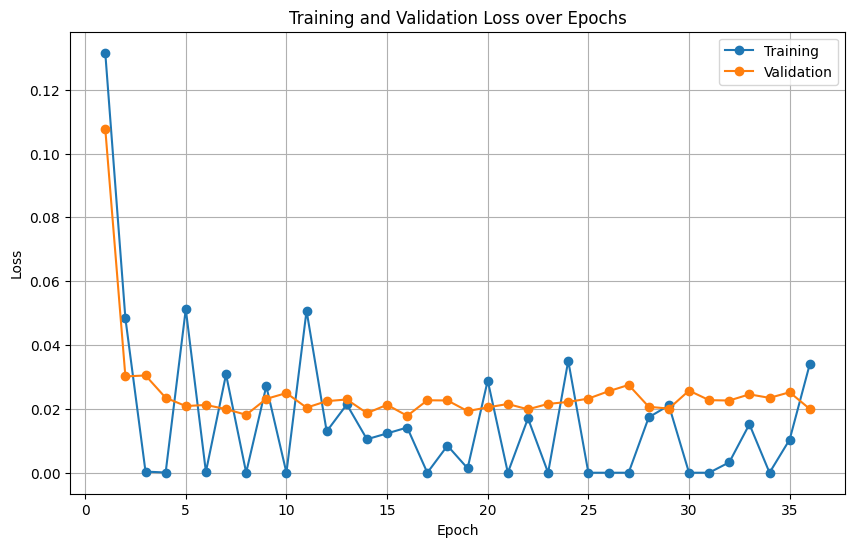

In [ ]:
plot_metrics(train_df= trainm_df, val_df = valm_df , metric_column = 'Loss')

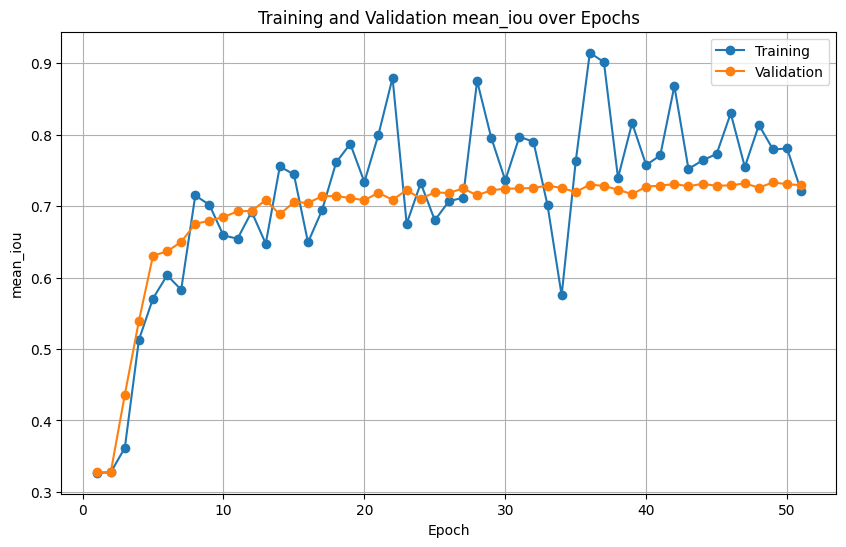

In [ ]:
plot_metrics(train_df= trainm_df, val_df = valm_df , metric_column = 'mean_iou')

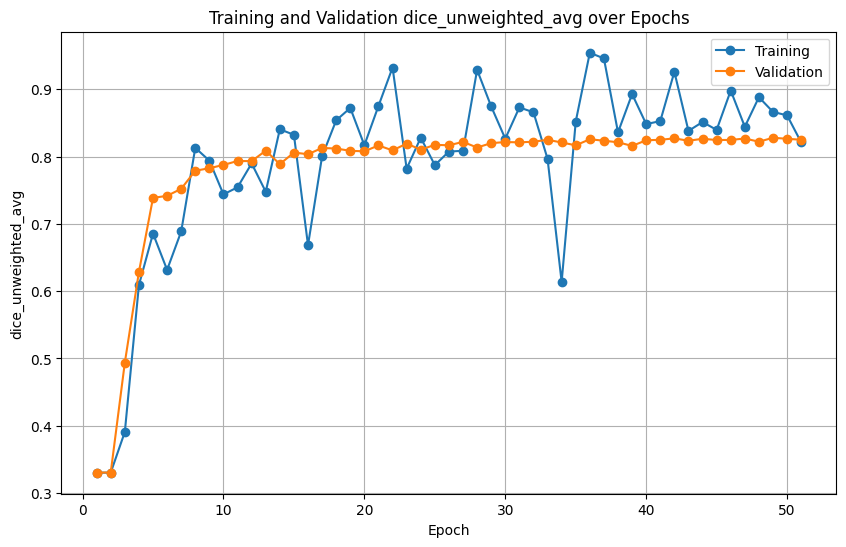

In [ ]:
plot_metrics(train_df= trainm_df, val_df = valm_df , metric_column = 'dice_unweighted_avg')

In [ ]:
import math

def plot_all_metrics(train_df, val_df):
    # Get all metric columns from the training dataframe
    metric_columns = [col for col in train_df.columns]

    # Calculate the number of rows needed based on the number of columns and desired layout
    num_plots = len(metric_columns)
    n = 3
    num_rows = math.ceil(num_plots / n)
    num_cols = min(num_plots, n)

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten axs if it's a 2D array (i.e., more than one row)
    if num_rows > 1:
        axs = axs.flatten()

    # Plot each metric
    for i, metric_column in enumerate(metric_columns):
        # Choose the subplot
        if num_rows > 1:
            ax = axs[i]
        else:
            ax = axs

        # Plot training metric
        ax.plot(train_df.index.tolist(), train_df[metric_column], label=f'Training {metric_column}', marker='o')

        # Plot validation metric
        ax.plot(val_df.index.tolist(), val_df[metric_column], label=f'Validation {metric_column}', marker='o')

        # Customize the subplot
        ax.set_title(f'{metric_column} over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric_column)
        #ax.legend()
        ax.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


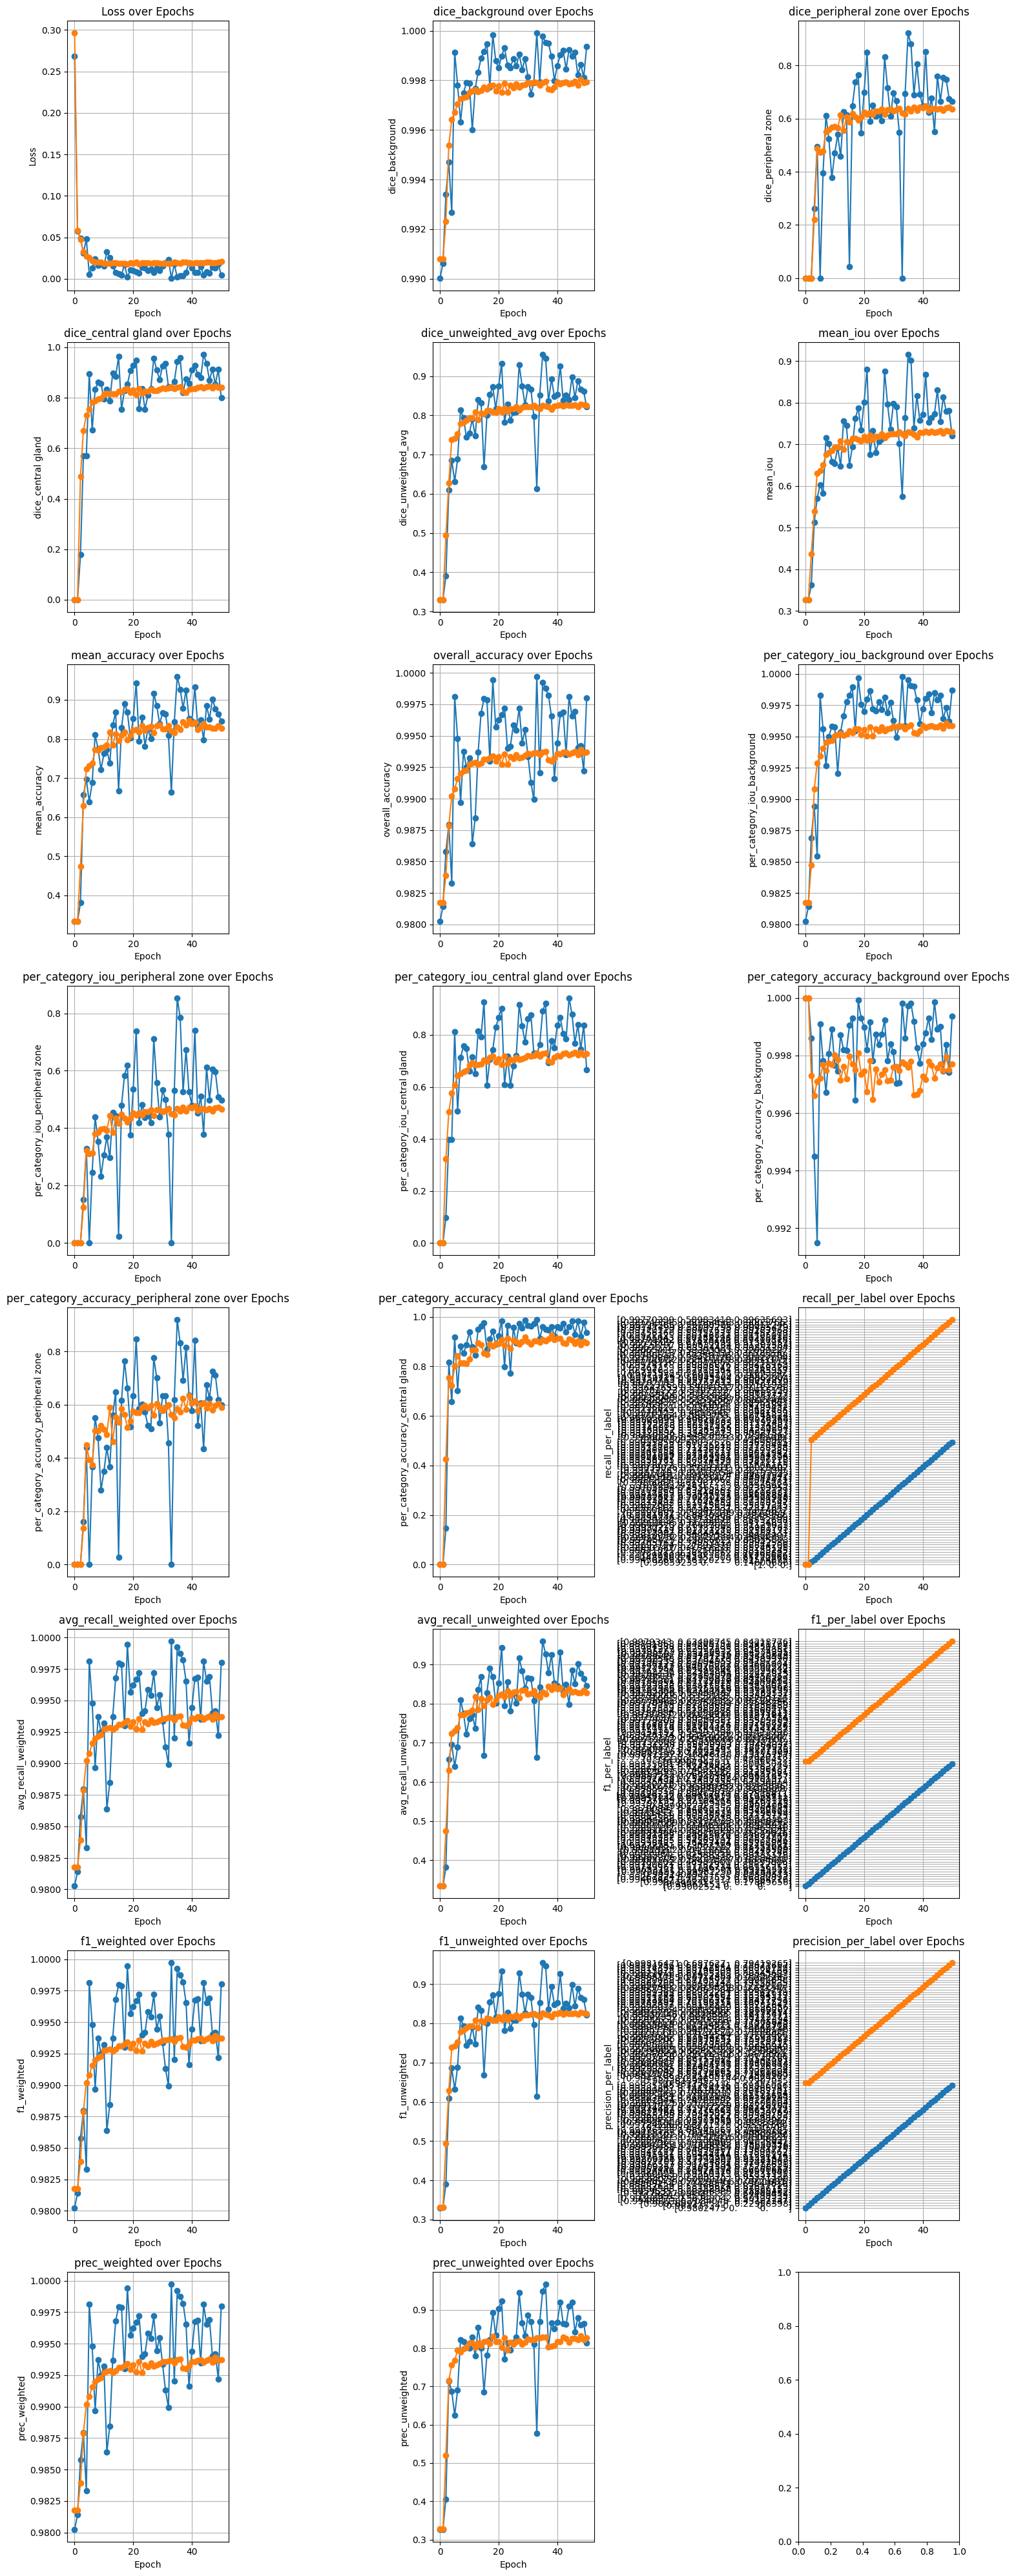

In [ ]:
plot_all_metrics(train_df= trainm_df, val_df = valm_df )

## Inference: Model test set evaluation

In [ ]:
load_model = True
if load_model:
  model_path = "/content/drive/MyDrive/Project/models/checkpoints/20240207_17_epoch_50_SegFormer_aug_eq.pt"
  model = torch.load(model_path)

In [ ]:
%%time
test_images, test_labels, test_predictions, test_metrics = model_eval(model=model, test_dataloader=test_loader,
                                                                      metric=mean_iou, dice_coef_metric=dice_coefficient)

In [ ]:
#test_images = torch.squeeze(test_images)

In [ ]:
def display_image_with_mask_i_h_w(image, mask, alpha=0.35):
    num_slices = image.shape[0]
    fig, axes = plt.subplots(1, num_slices, figsize=(50, 50))

    for i in range(num_slices):

        axes[i].imshow(image[i, :, :], cmap='gray')
        axes[i].set_title(f'Slice {i + 1}')

        axes[i].imshow(mask[i, :, :], cmap='Reds', alpha=alpha)

    plt.show()

ss = 10
es = 20
# GT
print(f'Ground truth')
display_image_with_mask_i_h_w(test_images[ss:es].cpu().numpy(), test_labels[ss:es].cpu().numpy(), alpha=0.35)
# Predictions
print(f'Predictions')
display_image_with_mask_i_h_w(test_images[ss:es].cpu().numpy(), test_predictions[ss:es].cpu().numpy(), alpha=0.35)

In [ ]:
ss = 10
es = 18
# GT
print(f'Ground truth')
display_image_with_mask_i_h_w(test_images[ss:es].cpu().numpy(), test_labels[ss:es].cpu().numpy(), alpha=0.35)
# Predictions
print(f'Predictions')
display_image_with_mask_i_h_w(test_images[ss:es].cpu().numpy(), test_predictions[ss:es].cpu().numpy(), alpha=0.35)